In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载三个模型的误分类样本数据
xgboost_df = pd.read_csv('./XGBoost_misclassified_samples.csv')
lightgbm_df = pd.read_csv('./LightGBM_misclassified_samples.csv')
svm_df = pd.read_csv('./SVM_misclassified_samples.csv')

In [3]:
import torch
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve



# 数据预处理
df = pd.read_csv('../imputed_selected_features_Flam.csv')
labels = df['Flammability'].values
smiles_list = df['SMILES'].tolist()

# 函数：将SMILES转换为分子描述符和指纹
def smiles_to_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # 提取描述符
    descriptors = [
        Descriptors.MolWt(mol),  # 分子量
        Descriptors.MolLogP(mol),  # LogP
        Descriptors.NumHDonors(mol),  # 氢键供体数量
        Descriptors.NumHAcceptors(mol)  # 氢键受体数量
    ]
    # 生成Morgan指纹
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprint_array = np.zeros((2048,))
    Chem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    # 合并描述符和指纹
    features = np.concatenate([descriptors, fingerprint_array])
    return features

# 将SMILES转换为特征
features = []
for smiles in smiles_list:
    feature = smiles_to_features(smiles)
    if feature is not None:
        features.append(feature)

# 转换为numpy数组
features = np.array(features)

y = labels
X = np.array(features)

In [4]:
# 合并数据
all_misclassified = pd.concat([xgboost_df, lightgbm_df, svm_df])

# 统计高频误分类样本（同一个SMILES被误分类的次数）
sample_counts = all_misclassified['index'].value_counts()

# 找出高频误分类的样本（出现在至少两折的样本）
high_freq_samples = sample_counts[sample_counts >= 2]

# 提取出高频误分类样本的详细信息
high_freq_misclassified = all_misclassified[all_misclassified['index'].isin(high_freq_samples.index)]

In [5]:
# 合并三个 DataFrame 的 'index' 列
high_indices = high_freq_misclassified['index']

# 去除重复的 index
unique_indices = high_indices.drop_duplicates()

# 计算不重复的 index 数量
unique_count = len(unique_indices)

In [6]:
unique_count

22

In [7]:
# 合并三个 DataFrame 的 'index' 列
high_indices = all_misclassified['index']

# 去除重复的 index
unique_indices = high_indices.drop_duplicates()

# 计算不重复的 index 数量
unique_count = len(unique_indices)
print(unique_count)

28


In [8]:
high_freq_misclassified

,fold,index,X,y,y_prob
0,1,152,[233.098 3.0869 1. ... 0. 0. ...,0,0.979290
1,1,286,[106.95 1.5248 0. ... 0. 0. ...,0,0.870519
3,1,635,[171.037 2.75752 0. ... 0. ...,0,0.994778
4,1,655,[291.992 5.9672 0. ... 0. 0. ...,1,0.379341
5,1,680,[88.154 -0.316 2. ... 0. 0. 0. ],0,0.999187
...,...,...,...,...,...
16,4,690,[265.401 1.577 1. ... 0. 0. ...,0,0.929062
17,5,231,[126.111 0.8034 3. ... 0. 0. ...,0,0.970571
18,5,385,[186.258 1.0026 0. ... 0. 0. ...,0,0.970371
19,5,609,[138.254 3.0786 0. ... 0. 0. ...,0,0.974785


In [9]:
all_misclassified

,fold,index,X,y,y_prob
0,1,152,[233.098 3.0869 1. ... 0. 0. ...,0,0.979290
1,1,286,[106.95 1.5248 0. ... 0. 0. ...,0,0.870519
2,1,329,[220.356 4.29562 1. ... 0. ...,1,0.176971
3,1,635,[171.037 2.75752 0. ... 0. ...,0,0.994778
4,1,655,[291.992 5.9672 0. ... 0. 0. ...,1,0.379341
...,...,...,...,...,...
16,4,690,[265.401 1.577 1. ... 0. 0. ...,0,0.929062
17,5,231,[126.111 0.8034 3. ... 0. 0. ...,0,0.970571
18,5,385,[186.258 1.0026 0. ... 0. 0. ...,0,0.970371
19,5,609,[138.254 3.0786 0. ... 0. 0. ...,0,0.974785


In [10]:
xgboost_df.shape

(24, 5)

In [11]:
lightgbm_df.shape

(22, 5)

In [12]:
svm_df.shape

(21, 5)

In [13]:
# 提取 index 列
xgboost_indices = xgboost_df['index']
lightgbm_indices = lightgbm_df['index']

# 查找相同的 index 数量
common_indices = len(pd.merge(xgboost_df[['index']], lightgbm_df[['index']], on='index'))

# 输出结果
print(f"Number of common samples between xgboost_df and lightgbm_df: {common_indices}")


Number of common samples between xgboost_df and lightgbm_df: 20


In [14]:
# 提取 index 列
xgboost_indices = xgboost_df['index']
svm_indices = svm_df['index']

# 查找相同的 index 数量
common_indices = len(pd.merge(xgboost_df[['index']], svm_df[['index']], on='index'))

# 输出结果
print(f"Number of common samples between xgboost_df and svm_df: {common_indices}")

Number of common samples between xgboost_df and svm_df: 17


In [15]:
# 提取 index 列
lightgbm_indices = lightgbm_df['index']
svm_indices = svm_df['index']

# 查找相同的 index 数量
common_indices = len(pd.merge(lightgbm_df[['index']], svm_df[['index']], on='index'))

# 输出结果
print(f"Number of common samples between lightgbm_df and svm_df: {common_indices}")



Number of common samples between lightgbm_df and svm_df: 19


In [16]:
# 合并 lightgbm_df 和 xgboost_df
merged_lgb_xgb = pd.merge(lightgbm_df[['index']], xgboost_df[['index']], on='index')

# 然后再合并 randomforest_df
merged_all = pd.merge(merged_lgb_xgb, svm_df[['index']], on='index')

# 查找相同的 index 数量
common_indices = len(merged_all)

# 输出结果
print(f"Number of common samples between svm_df, lightgbm_df and xgboost_df: {common_indices}")


Number of common samples between svm_df, lightgbm_df and xgboost_df: 17


In [17]:
# 合并三个 DataFrame 的 'index' 列
all_indices = pd.concat([lightgbm_df[['index']], xgboost_df[['index']], svm_df[['index']]])

# 去除重复的 index
unique_indices = all_indices.drop_duplicates()

# 计算不重复的 index 数量
unique_count = len(unique_indices)

# 输出结果
print(f"Number of unique samples across svm_df, lightgbm_df and xgboost_df: {unique_count}")


Number of unique samples across svm_df, lightgbm_df and xgboost_df: 28


In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# 设置集合的大小和交集
venn_data = {
    '100': 4,  # 仅XGB  24
    '010': 0,   # 仅LGB  22
    '001': 2,     # 仅SVM  21
    '110': 3,   # XGB和LGB的交集  20
    '101': 0,     # XGB和SVM的交集  17
    '011': 2,     # LGB和SVM的交集  19
    '111': 17      # XGB、SVM和LGB的交集  17
}


In [19]:
unique_indices

,index
0,152
1,286
2,635
3,655
4,680
5,72
6,279
7,300
8,683
9,251


In [20]:
ZZ = X[unique_indices]

In [21]:
ZZ.shape

(28, 1, 2052)

In [22]:
zz_y = y[unique_indices]

In [23]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [24]:
zz_y

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]])

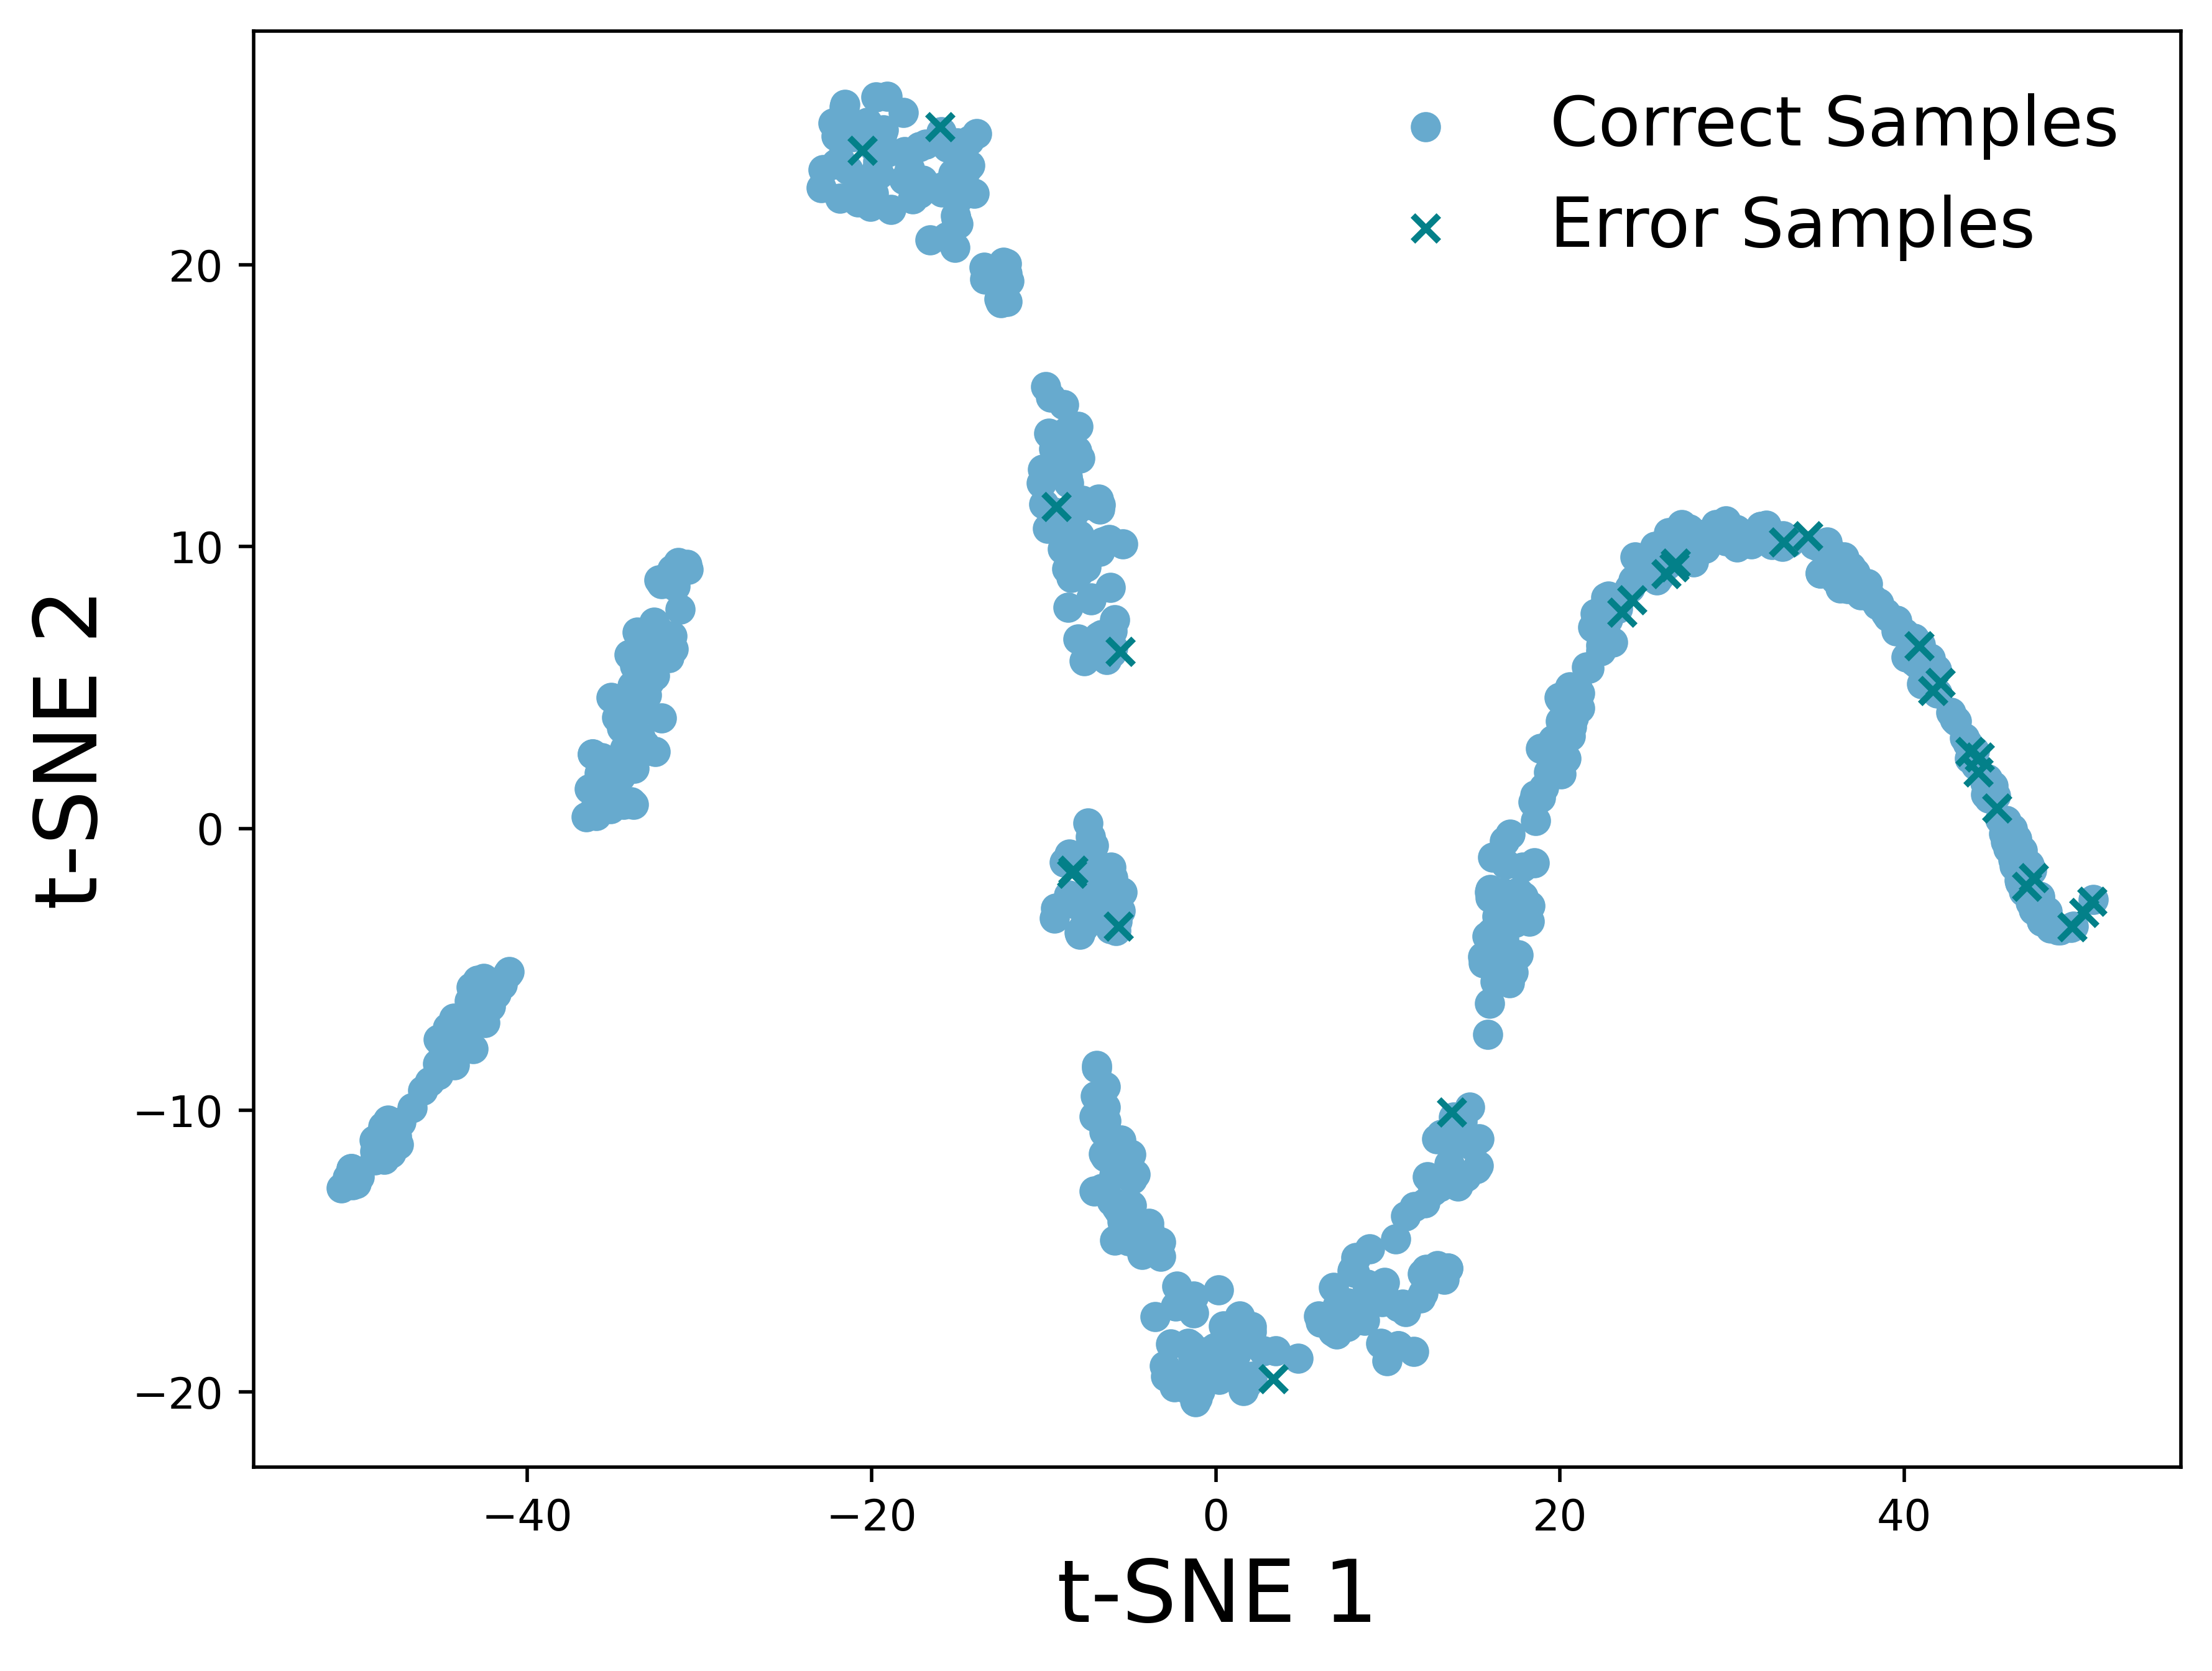

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager
# 指定字体路径
font_path = './times.ttf'
prop = font_manager.FontProperties(fname=font_path)



# 假设X, y, ZZ, zz_y 已经准备好
# 使用t-SNE进行降维，处理全部样本
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# 创建一个布尔数组来区分错误样本
is_error = np.zeros(len(X), dtype=bool)  # 默认为正确样本
is_error[high_indices] = True  # 将错误样本标记为True

# 绘制全部样本的2D散点图
plt.figure(figsize=(8, 6), dpi=500)

# 使用不同颜色绘制错误样本和正确样本
plt.scatter(X_2d[~is_error, 0], X_2d[~is_error, 1], c='#67AACE', marker='o', label='Correct Samples')
plt.scatter(X_2d[is_error, 0], X_2d[is_error, 1], c='#038089', marker='x', label='Error Samples')


plt.xlabel('t-SNE 1',fontsize=20)
plt.ylabel('t-SNE 2',fontsize=20)
plt.legend(frameon=False,fontsize=16)
plt.show()


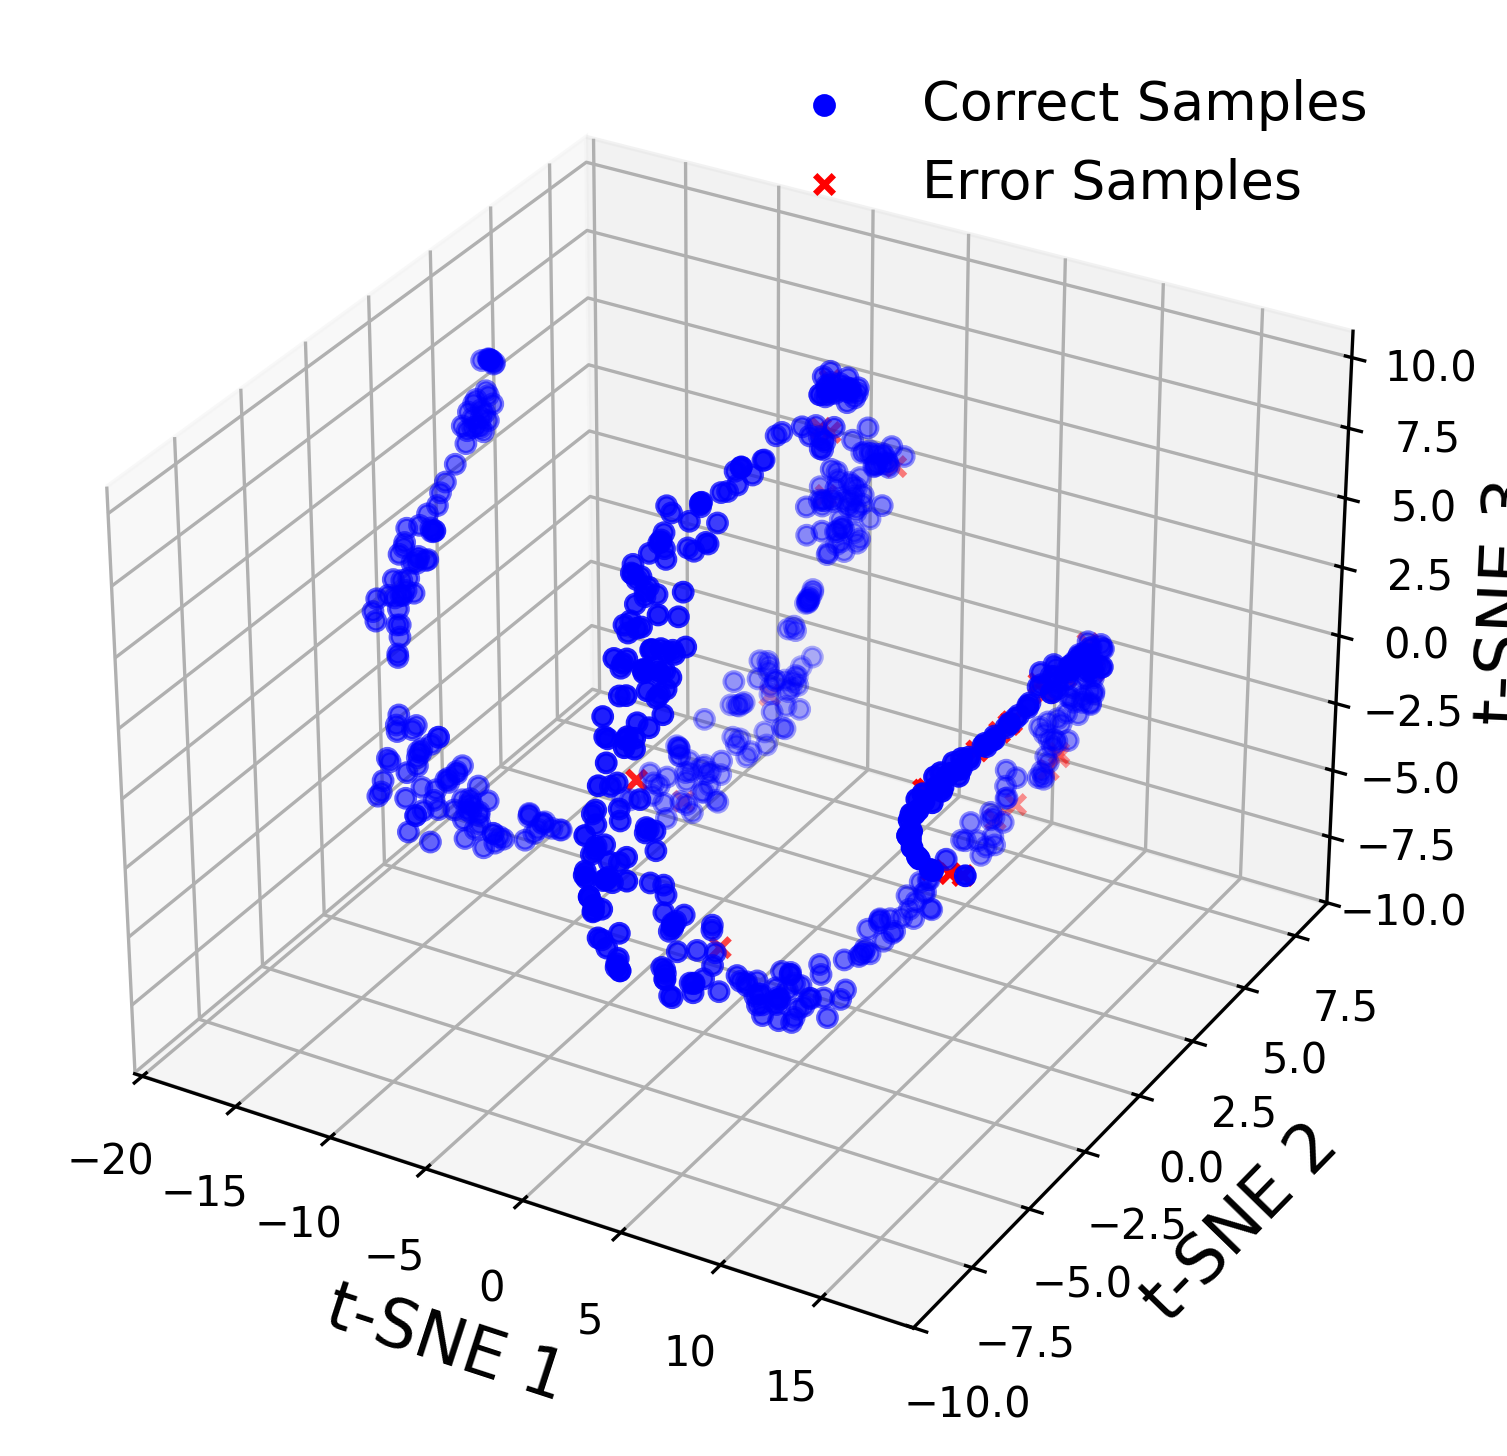

In [30]:
# 使用t-SNE降到3维
tsne_3d = TSNE(n_components=3, random_state=42)
X_3d_tsne = tsne_3d.fit_transform(X)

# 创建一个布尔数组来区分错误样本
is_error = np.zeros(len(X), dtype=bool)  # 默认为正确样本
is_error[unique_indices] = True  # 将错误样本标记为True

# 绘制3D散点图
fig = plt.figure(figsize=(8, 6),dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 使用不同颜色绘制错误样本和正确样本
ax.scatter(X_3d_tsne[~is_error, 0], X_3d_tsne[~is_error, 1], X_3d_tsne[~is_error, 2], c='blue', marker='o', label='Correct Samples')
ax.scatter(X_3d_tsne[is_error, 0], X_3d_tsne[is_error, 1], X_3d_tsne[is_error, 2], c='red', marker='x', label='Error Samples')

#ax.set_title('t-SNE 3D Projection of ZZ with Correct and Error Samples')
ax.set_xlabel('t-SNE 1',fontsize=16)
ax.set_ylabel('t-SNE 2',fontsize=16)
ax.set_zlabel('t-SNE 3',fontsize=16)

ax.legend(frameon=False,fontsize=13)
plt.show()


In [31]:
y_prob = xgboost_df['y_prob']


In [32]:
high_freq_misclassified

,fold,index,X,y,y_prob
0,1,18,[98.189 2.7307 0. ... 0. 0. ...,0,0.727199
1,1,154,[262.437 5.8556 1. ... 0. 0. ...,0,0.654058
2,1,237,[ 7.2063e+01 -6.6700e-02 0.0000e+00 ... 0.00...,0,0.753190
3,1,262,[446.672 7.9934 0. ... 0. 0. ...,0,0.624084
5,1,333,[144.214 1.9841 0. ... 0. 0. ...,0,0.652604
...,...,...,...,...,...
80,5,519,[282.292 1.293 0. ... 0. 0. ...,0,0.726143
81,5,529,[128.215 2.5458 0. ... 0. 0. ...,0,0.801503
82,5,530,[414.359 1.41432 2. ... 0. ...,0,0.711788
83,5,620,[82.146 2.1386 0. ... 0. 0. ...,0,0.810474
